In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np 


from pytranskit.optrans.continuous.cdt import CDT

from layers.ect import EctLayer
from layers.config import EctConfig

from datasets.pointclouds import PointCloudDataModule, PointCloudDataModuleConfig 




Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
NUM_PTS = 2
DEVICE = 'cuda:0'
NUM_THETAS = 64




dataset = PointCloudDataModule(PointCloudDataModuleConfig(num_points=2))
for batch in dataset.train_dataloader():
    break
batch = batch.to(DEVICE)




In [44]:
V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
        # torch.zeros_like(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE))
    ]
)

CONFIG = EctConfig(device=DEVICE,bump_steps=NUM_THETAS,num_thetas=NUM_THETAS,normalized=True)
ectlayer = EctLayer(config = CONFIG,V=V)

encoder = nn.Sequential(
            nn.Conv1d(64,128,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv1d(128,256,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv1d(256,256,kernel_size=3,stride=2),
            nn.Flatten(),
            nn.Linear(1792,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,2),
        ).to(DEVICE)


batch_ect = ectlayer(batch).movedim(-1,-2)



res = encoder(batch_ect)

res.shape


torch.Size([64, 2])

In [28]:
batch_ect.shape

# plt.plot(batch_ect[0][0].squeeze().cpu().numpy())

torch.Size([64, 64, 64])

In [25]:



res.shape




# plt.plot(res[0].cpu().detach().numpy())
# res[0].cpu().detach().numpy()

torch.Size([256, 62])

In [36]:
from torch import strided


m = nn.Conv1d(64, 128, 3,stride=2)
input = torch.randn(1, 64, 64).to(DEVICE)
output = encoder(input)
output.shape

torch.Size([1, 128, 62])

In [134]:
torch.save(model,"./trained_models/model.pt")


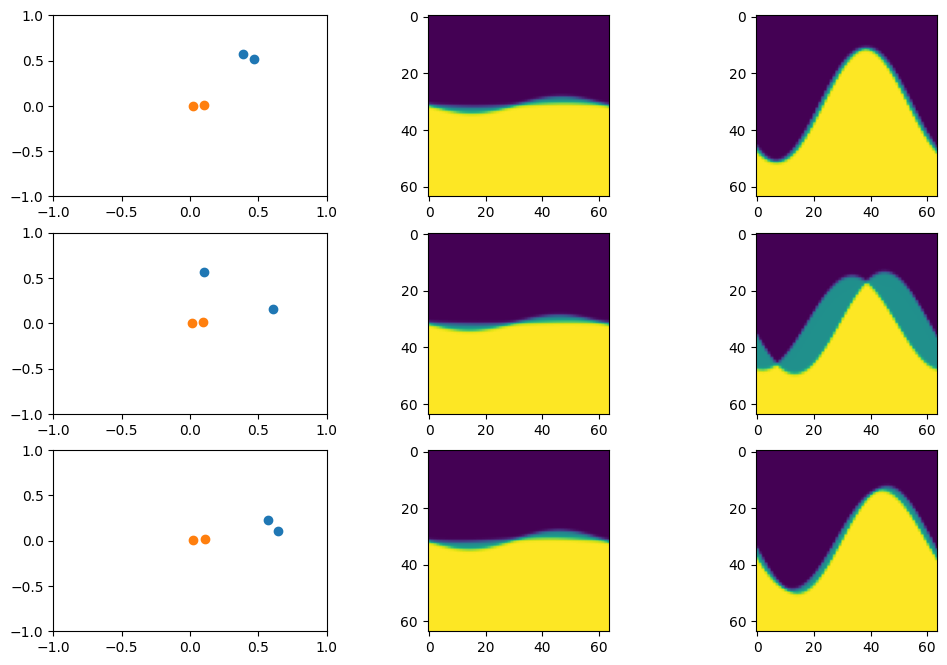

In [216]:
for test_batch in dataset.test_dataloader():
    break

recon_batch, internal_batch = model(test_batch.to(DEVICE))



indices = [1,6,2]


fig, axes = plt.subplots(len(indices),3,figsize=(12,8))

for idx,batch_idx in enumerate(indices):
    pred = internal_batch.x[NUM_PTS*batch_idx:NUM_PTS*batch_idx+NUM_PTS].cpu().detach().numpy()
    points = test_batch[batch_idx].x.cpu().detach().numpy()

    ax = axes[idx,0]
    # ax.axis("off")
    ax.scatter(points[:,0],points[:,1])
    ax.scatter(pred[:,0],pred[:,1])
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])

    ax = axes[idx,1]
    # ax.axis("off")
    ax.imshow(recon_batch[batch_idx].cpu().squeeze().detach().numpy())

    ax = axes[idx,2]
    # ax.axis("off")
    ax.imshow(internal_batch.ect[batch_idx].cpu().squeeze().detach().numpy())


In [16]:

def ect_interp(ect_start, ect_end):
    N=NUM_THETAS
    x0 = np.linspace(0, 1, N)
    I0= np.ones(x0.size)
    x=np.linspace(0, 2, N)
    num_thetas = NUM_THETAS
    ect = np.zeros((num_thetas,num_thetas))
    I1 = abs(ect_start) + 1e-7
    I2 = abs(ect_end) + 1e-7

    I1 = I1/I1.sum(axis=0)
    I2 = I2/I2.sum(axis=0)
    
    taus = np.linspace(0,1,100)
    cdt1 = CDT()
    inter = []

    for tau in taus: 
        for idx in range(num_thetas):
            # Compute the forward transform
            I1_hat, I1_hat_old, xtilde = cdt1.forward(x0, I0, x, I1[:,idx], rm_edge=False)
            I2_hat, I2_hat_old, xtilde = cdt1.forward(x0, I0, x, I2[:,idx], rm_edge=False)


            I_hat = ( tau ) * I1_hat + ( 1 - tau ) * I2_hat  
            I_recon = cdt1.inverse(I_hat, I0, x)

            ect[:,idx] = I_recon
            
        inter.append(ect)
        ect = np.zeros((num_thetas,num_thetas))
    return np.stack(inter)

In [17]:

derlayer = EctLayer(config = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,device=DEVICE,ect_type="points_derivative"))
derlayer.v = V




# test_batch = Batch.from_data_list([Data(x=torch.tensor([[.4,0]],dtype=torch.float32)), Data(x=torch.tensor([[0,0.4]],dtype=torch.float32))]).to(DEVICE)

ect_batch_der = derlayer(test_batch)
ect_batch_linear = ectlayer(test_batch)

ect_start_der = ect_batch_der[0].cpu().squeeze().detach()
ect_end_der = ect_batch_der[25].cpu().squeeze().detach() 

ect_start_linear = ect_batch_linear[0].cpu().squeeze().detach()
ect_end_linear = ect_batch_linear[25].cpu().squeeze().detach() 


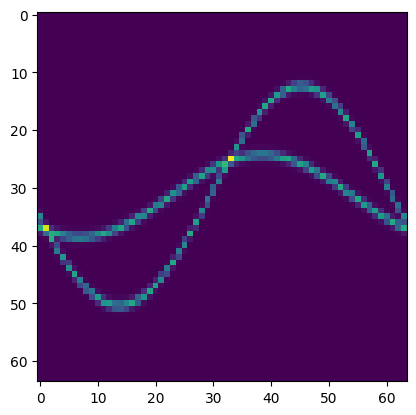

In [18]:
plt.imshow(ect_batch_der[0].squeeze().cpu().numpy())

In [19]:
interp_ect = torch.tensor(ect_interp(ect_start_der.numpy(),ect_end_der.numpy()),dtype=torch.float32,device=DEVICE).cumsum(dim=1)
lin = torch.linspace(0,1,100).view(-1,1,1)
interp_linear = lin * ect_start_linear.unsqueeze(0) + (1-lin) * ect_end_linear.unsqueeze(0)


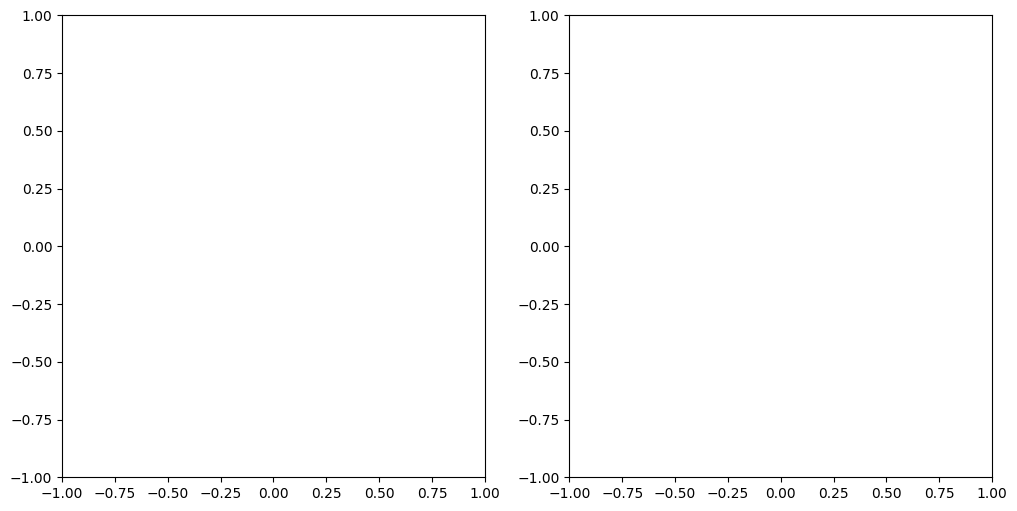

In [20]:
# batch = Batch.from_data_list([Data(x=el.squeeze()) for el in interp])

fig,axes = plt.subplots(1,2,figsize=(12,6))

axes[0].set_xlim([-1,1])
axes[0].set_ylim([-1,1])


axes[1].set_xlim([-1,1])
axes[1].set_ylim([-1,1])


for idx in range(100):
    pts = model.encoder(interp_ect[idx].view(1,NUM_THETAS,NUM_THETAS)).view(-1,2).cpu().detach().numpy()
    axes[0].scatter(pts[:100,0],pts[:100,1])
    pts_linear = model.encoder(interp_linear[idx].view(1,NUM_THETAS,NUM_THETAS).cuda()).view(-1,2).cpu().detach().numpy()
    axes[1].scatter(pts_linear[:100,0],pts_linear[:100,1])

plt.show()


In [21]:
# Pass batch through the encoder. 
pts_interp_ect = model.encoder(interp_ect.unsqueeze(1)).view(-1,2).detach().cpu().numpy()
pts_interp_linear = model.encoder(interp_linear.unsqueeze(1).cuda()).view(-1,2).detach().cpu().numpy()

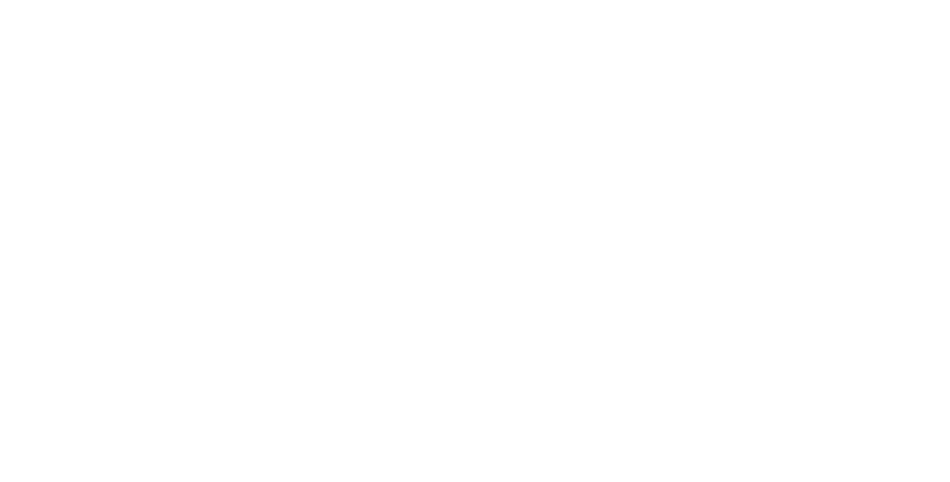

In [22]:
pts = pts_interp_ect[:NUM_PTS]
pts_linear = pts_interp_linear[:NUM_PTS]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax0 = axes[0]
ax0.axis("off")
ax0.set_xlim([-3,3])
ax0.set_ylim([-3,3])
scat = ax0.scatter(pts[:,0],pts[:,1])

ax0 = axes[1]
ax0.axis("off")
ax0.set_xlim([-3,3])
ax0.set_ylim([-3,3])
scat2 = ax0.scatter(pts_linear[:,0],pts_linear[:,1])


def update(idx):
    pts = pts_interp_ect[NUM_PTS*idx:NUM_PTS*idx+NUM_PTS]
    pts_linear = pts_interp_linear[NUM_PTS*idx:NUM_PTS*idx+NUM_PTS]
    scat.set_offsets(pts)
    scat2.set_offsets(pts_linear)


ani = animation.FuncAnimation(fig=fig, func=update, frames=100, interval=30)

from IPython.display import HTML
HTML(ani.to_jshtml())
